
- Transfer learning with pretrained Keras models

- Although Kernel resources were increased recently we still can not train useful CNNs without GPU. The original ImageNet set has quite a few different dog classes so we can reuse CNNs with pretrained ImageNet weights. Fortunately prediction is much faster (<1s/image) making it possible to run meaningful experiments with Kaggle Kernels.


In [2]:
data_path="M:\dataset\Dog_Breed_Identification"

In [3]:
%matplotlib inline
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from os import listdir, makedirs
from os.path import join, exists, expanduser
from tqdm import tqdm
from sklearn.metrics import log_loss, accuracy_score
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
from keras.applications import xception
from keras.applications import inception_v3
from keras.applications.vgg16 import preprocess_input, decode_predictions
from sklearn.linear_model import LogisticRegression

Using TensorFlow backend.



## Use Keras Pretrained Models dataset

- Kernels can't use network connection to download pretrained keras model weights. This dataset helps you to apply your favorite pretrained model in the Kaggle Kernel environment. You can find more details here.

We have to copy the pretrained models to the cache directory (~/.keras/models) where keras is looking for them.


In [6]:

INPUT_SIZE = 224
NUM_CLASSES = 120
SEED = 1987
data_dir =data_path
labels = pd.read_csv(join(data_dir, 'labels.csv'))
sample_submission = pd.read_csv(join(data_dir, 'sample_submission.csv'))
print(len(listdir(join(data_dir, 'train'))), len(labels))
print(len(listdir(join(data_dir, 'test'))), len(sample_submission))



10222 10222
10357 10357


In [7]:
labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [8]:

selected_breed_list = list(labels.groupby('breed').count().sort_values(by='id', ascending=False).head(NUM_CLASSES).index)
labels = labels[labels['breed'].isin(selected_breed_list)]
labels['target'] = 1
labels['rank'] = labels.groupby('breed').rank()['id']



In [9]:
labels.head()

,id,breed,target,rank
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull,1,1.0
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo,1,1.0
2,001cdf01b096e06d78e9e5112d419397,pekinese,1,1.0
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick,1,1.0
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever,1,1.0


In [10]:
labels_pivot = labels.pivot('id', 'breed', 'target').reset_index().fillna(0)
np.random.seed(seed=SEED)
rnd = np.random.random(len(labels))
train_idx = rnd < 0.8
valid_idx = rnd >= 0.8
y_train = labels_pivot[selected_breed_list].values
ytr = y_train[train_idx]
yv = y_train[valid_idx]

In [13]:
print(y_train.shape,ytr.shape,yv.shape)

(10222, 120) (8140, 120) (2082, 120)


In [14]:


def read_img(img_id, train_or_test, size):
    """Read and resize image.
    # Arguments
        img_id: string
        train_or_test: string 'train' or 'test'.
        size: resize the original image.
    # Returns
        Image as numpy array.
    """
    img = image.load_img(join(data_dir, train_or_test, '%s.jpg' % img_id), target_size=size)
    img = image.img_to_array(img)
    return img



## ResNet50 class predictions for example images¶

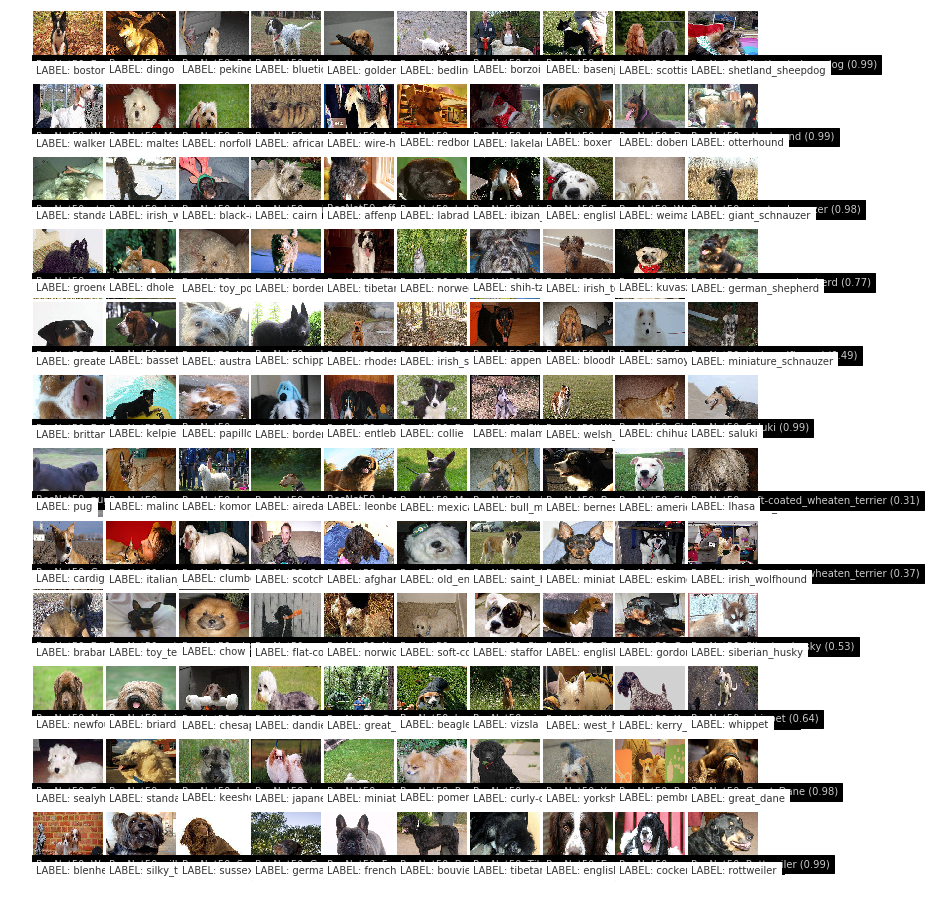

In [16]:
# Preprocessing and prediction seems to be working. 75% accuracy on these 16 images.
# 直接预测
model = ResNet50(weights='imagenet')

j = int(np.sqrt(NUM_CLASSES))
i = int(np.ceil(1. * NUM_CLASSES / j))
fig = plt.figure(1, figsize=(16, 16))
grid = ImageGrid(fig, 111, nrows_ncols=(i, j), axes_pad=0.05)
for i, (img_id, breed) in enumerate(labels.loc[labels['rank'] == 1, ['id', 'breed']].values):
    ax = grid[i]
    img = read_img(img_id, 'train', (224, 224))
    ax.imshow(img / 255.)
    x = preprocess_input(np.expand_dims(img.copy(), axis=0))
    preds = model.predict(x)
    _, imagenet_class_name, prob = decode_predictions(preds, top=1)[0][0]
    ax.text(10, 180, 'ResNet50: %s (%.2f)' % (imagenet_class_name , prob), color='w', backgroundcolor='k', alpha=0.8)
    ax.text(10, 200, 'LABEL: %s' % breed, color='k', backgroundcolor='w', alpha=0.8)
    ax.axis('off')
plt.show()


In [17]:
INPUT_SIZE = 224
POOLING = 'avg'
x_train = np.zeros((len(labels), INPUT_SIZE, INPUT_SIZE, 3), dtype='float32')
for i, img_id in tqdm(enumerate(labels['id'])):
    img = read_img(img_id, 'train', (INPUT_SIZE, INPUT_SIZE))
    x = preprocess_input(np.expand_dims(img.copy(), axis=0))
    x_train[i] = x
print('Train Images shape: {} size: {:,}'.format(x_train.shape, x_train.size))

10222it [00:52, 193.39it/s]


Train Images shape: (10222, 224, 224, 3) size: 1,538,697,216


## Extract VGG16 bottleneck features¶

In [18]:

Xtr = x_train[train_idx]
Xv = x_train[valid_idx]
print((Xtr.shape, Xv.shape, ytr.shape, yv.shape))
vgg_bottleneck = VGG16(weights='imagenet', include_top=False, pooling=POOLING)
train_vgg_bf = vgg_bottleneck.predict(Xtr, batch_size=32, verbose=1)
valid_vgg_bf = vgg_bottleneck.predict(Xv, batch_size=32, verbose=1)
print('VGG train bottleneck features shape: {} size: {:,}'.format(train_vgg_bf.shape, train_vgg_bf.size))
print('VGG valid bottleneck features shape: {} size: {:,}'.format(valid_vgg_bf.shape, valid_vgg_bf.size))


((8140, 224, 224, 3), (2082, 224, 224, 3), (8140, 120), (2082, 120))
2082/2082 [==============================] - 7s     
VGG train bottleneck features shape: (8140, 512) size: 4,167,680
VGG valid bottleneck features shape: (2082, 512) size: 1,065,984


In [19]:
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=SEED)
logreg.fit(train_vgg_bf, (ytr * range(NUM_CLASSES)).sum(axis=1))
valid_probs = logreg.predict_proba(valid_vgg_bf)
valid_preds = logreg.predict(valid_vgg_bf)

In [20]:

print('Validation VGG LogLoss {}'.format(log_loss(yv, valid_probs)))
print('Validation VGG Accuracy {}'.format(accuracy_score((yv * range(NUM_CLASSES)).sum(axis=1), valid_preds)))


Validation VGG LogLoss 2.397276822434741
Validation VGG Accuracy 0.6695485110470701


## Extract Xception bottleneck features

In [23]:


INPUT_SIZE = 299
POOLING = 'avg'
x_train = np.zeros((len(labels), INPUT_SIZE, INPUT_SIZE, 3), dtype='float32')
for i, img_id in tqdm(enumerate(labels['id'])):
    img = read_img(img_id, 'train', (INPUT_SIZE, INPUT_SIZE))
    x = xception.preprocess_input(np.expand_dims(img.copy(), axis=0))
    x_train[i] = x
print('Train Images shape: {} size: {:,}'.format(x_train.shape, x_train.size))


1036it [00:04, 218.01it/s]


KeyboardInterrupt: 

In [22]:

Xtr = x_train[train_idx]
Xv = x_train[valid_idx]
print((Xtr.shape, Xv.shape, ytr.shape, yv.shape))
xception_bottleneck = xception.Xception(weights='imagenet', include_top=False, pooling=POOLING)
train_x_bf = xception_bottleneck.predict(Xtr, batch_size=32, verbose=1)
valid_x_bf = xception_bottleneck.predict(Xv, batch_size=32, verbose=1)
print('Xception train bottleneck features shape: {} size: {:,}'.format(train_x_bf.shape, train_x_bf.size))
print('Xception valid bottleneck features shape: {} size: {:,}'.format(valid_x_bf.shape, valid_x_bf.size))


((8140, 299, 299, 3), (2082, 299, 299, 3), (8140, 120), (2082, 120))
2080/2082 [============================>.] - ETA: 0sXception train bottleneck features shape: (8140, 2048) size: 16,670,720
Xception valid bottleneck features shape: (2082, 2048) size: 4,263,936


In [24]:

logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=SEED)
logreg.fit(train_x_bf, (ytr * range(NUM_CLASSES)).sum(axis=1))
valid_probs = logreg.predict_proba(valid_x_bf)
valid_preds = logreg.predict(valid_x_bf)
print('Validation Xception LogLoss {}'.format(log_loss(yv, valid_probs)))
print('Validation Xception Accuracy {}'.format(accuracy_score((yv * range(NUM_CLASSES)).sum(axis=1), valid_preds)))


Validation Xception LogLoss 0.35266317070045894
Validation Xception Accuracy 0.8933717579250721


## Extract Inception bottleneck features

In [25]:

Xtr = x_train[train_idx]
Xv = x_train[valid_idx]
print((Xtr.shape, Xv.shape, ytr.shape, yv.shape))
inception_bottleneck = inception_v3.InceptionV3(weights='imagenet', include_top=False, pooling=POOLING)
train_i_bf = inception_bottleneck.predict(Xtr, batch_size=32, verbose=1)
valid_i_bf = inception_bottleneck.predict(Xv, batch_size=32, verbose=1)
print('InceptionV3 train bottleneck features shape: {} size: {:,}'.format(train_i_bf.shape, train_i_bf.size))
print('InceptionV3 valid bottleneck features shape: {} size: {:,}'.format(valid_i_bf.shape, valid_i_bf.size))


((8140, 299, 299, 3), (2082, 299, 299, 3), (8140, 120), (2082, 120))
2082/2082 [==============================] - 10s    
InceptionV3 train bottleneck features shape: (8140, 2048) size: 16,670,720
InceptionV3 valid bottleneck features shape: (2082, 2048) size: 4,263,936


In [26]:

logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=SEED)
logreg.fit(train_i_bf, (ytr * range(NUM_CLASSES)).sum(axis=1))
valid_probs = logreg.predict_proba(valid_i_bf)
valid_preds = logreg.predict(valid_i_bf)

print('Validation Inception LogLoss {}'.format(log_loss(yv, valid_probs)))
print('Validation Inception Accuracy {}'.format(accuracy_score((yv * range(NUM_CLASSES)).sum(axis=1), valid_preds)))



Validation Inception LogLoss 4.331010772326103
Validation Inception Accuracy 0.09750240153698367



## LogReg on all bottleneck features

- Full train bottleneck features shape: (8140, 4096) size: 33,341,440
- Full valid bottleneck features shape: (2082, 4096) size: 8,527,872
- Validation Xception + Inception LogLoss 0.36467213112234403
- Validation Xception + Inception Accuracy 0.8933717579250721


In [30]:


X = np.hstack([train_x_bf, train_i_bf])
V = np.hstack([valid_x_bf, valid_i_bf])
print('Full train bottleneck features shape: {} size: {:,}'.format(X.shape, X.size))
print('Full valid bottleneck features shape: {} size: {:,}'.format(V.shape, V.size))
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=SEED)
logreg.fit(X, (ytr * range(NUM_CLASSES)).sum(axis=1))
valid_probs = logreg.predict_proba(V)
valid_preds = logreg.predict(V)
print('Validation Xception + Inception LogLoss {}'.format(log_loss(yv, valid_probs)))
print('Validation Xception + Inception Accuracy {}'.format(accuracy_score((yv * range(NUM_CLASSES)).sum(axis=1), valid_preds)))


Full train bottleneck features shape: (8140, 4096) size: 33,341,440
Full valid bottleneck features shape: (2082, 4096) size: 8,527,872
Validation Xception + Inception LogLoss 0.36467213112234403
Validation Xception + Inception Accuracy 0.8933717579250721


In [45]:
import cv2
df2 = pd.read_csv(join(data_dir,'sample_submission.csv'))

width=299
n_test = len(df2)
X_test = np.zeros((n_test, width, width, 3), dtype=np.uint8)
for i in tqdm(range(n_test)):
    img = read_img(df2['id'][i], 'test', (INPUT_SIZE, INPUT_SIZE))
    x = xception.preprocess_input(np.expand_dims(img.copy(), axis=0))
    X_test[i]=x
    # X_test[i] = cv2.resize(cv2.imread(join(data_dir,'test/%s.jpg' % df2['id'][i])), (width, width))
      


100%|███████████████████████████████████████████████████████████████████████████| 10357/10357 [00:44<00:00, 233.64it/s]


In [69]:

print(X_test.shape)
inception_bottleneck = inception_v3.InceptionV3(weights='imagenet', include_top=False, pooling=POOLING)
test_i_bf = inception_bottleneck.predict(X_test, batch_size=32, verbose=1)

xception_bottleneck = xception.Xception(weights='imagenet', include_top=False, pooling=POOLING)
test_x_bf = xception_bottleneck.predict(X_test, batch_size=32, verbose=1)


print('InceptionV3 train bottleneck features shape: {} size: {:,}'.format(test_i_bf.shape, test_x_bf.size))


(10357, 299, 299, 3)
10357/10357 [==============================] - 69s    
InceptionV3 train bottleneck features shape: (10357, 2048) size: 21,211,136


In [77]:
V = np.hstack([test_x_bf, test_i_bf])
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=SEED)
logreg.fit(X, (ytr * range(NUM_CLASSES)).sum(axis=1))
test_probs = logreg.predict_proba(V)

test_preds = logreg.predict(V)
#print(test_probs)

In [78]:
# print(test_probs)
print(test_probs.shape)
df =  pd.read_csv(join(data_dir, 'labels.csv'))
df.head()

n = len(df)
breed = set(df['breed'])
n_class = len(breed)
class_to_num = dict(zip(breed, range(n_class)))
num_to_class = dict(zip(range(n_class), breed))

#print(class_to_num)
#print(breed)

(10357, 120)


In [79]:
df.head()
n_test = len(df2)
print(n_test)


#test_probs = test_probs.clip(min=0.005, max=0.995)

10357


In [80]:
#print(n,breed,n_class,class_to_num)

for b in breed:
    df2[b] =test_probs[:,class_to_num[b]]


df2.to_csv('method1_pred.csv', index=None)



## Check errors

We still have a few misclassification errors.


```
valid_breeds = (yv * range(NUM_CLASSES)).sum(axis=1)
error_idx = (valid_breeds != valid_preds)
k=0
for img_id, breed, pred in zip(labels.loc[valid_idx, 'id'].values[error_idx],
                                [selected_breed_list[int(b)] for b in valid_preds[error_idx]],
                                [selected_breed_list[int(b)] for b in valid_breeds[error_idx]]):
    fig, ax = plt.subplots(figsize=(5,5))
    img = read_img(img_id, 'train', (299, 299))
    ax.imshow(img / 255.)
    ax.text(10, 250, 'Prediction: %s' % pred, color='w', backgroundcolor='r', alpha=0.8)
    ax.text(10, 270, 'LABEL: %s' % breed, color='k', backgroundcolor='g', alpha=0.8)
    ax.axis('off')
    plt.show()
    k=k+1
    if k==20:
        break
    
```